# RNN: Hyperparameter Optimization

In [1]:
import os
import numpy as np
import pandas as pd

# for printing the definition of custom functions
import inspect

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

import pickle


C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\hauer\anaconda3\envs\test\lib\site-packages\sklearn\externals\joblib\__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [2]:
models = []
n_epochs = 10

In [3]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database_new.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

In [4]:
# =============================================================================
# RNN start
# =============================================================================


# =============================================================================
# # Prepare Data for RNN
# =============================================================================


# Combining orignal training and 
database_training = {}

for country in database_training_sv_standard.keys():
    df_to_add = database_training_sv_standard[country].append(database_validation_sv_standard[country])
    df_to_add = df_to_add.reset_index()
    del df_to_add['index']

    database_training[country] = df_to_add


N, dummy_dim = database_training['Germany'].shape
dummy_dim -= 1

time_steps = 16
horizon = 1
sequence_length = time_steps + horizon 


max_index = N - sequence_length + 1

number_of_countries = len(database_training.keys())

X = np.empty([0, sequence_length,dummy_dim])
y = np.empty([0, sequence_length])

 

for country in database_training.keys():
    df_training_current = database_training[country]

    X_current = np.empty([max_index, sequence_length,dummy_dim])
    y_current = np.empty([max_index, sequence_length])

    for i in range(max_index):

        X_current[i] = df_training_current.iloc[i:i+sequence_length,1:].values
        y_current[i] = df_training_current.iloc[i:i+sequence_length,0].values
        
    X = np.concatenate((X, X_current))
    y = np.concatenate((y, y_current))
    
    
    

N, seq_len, dummy_dim = X.shape

input_size=dummy_dim
n_layers=1
output_size=1
test_size = 0.20
batch_size = 25




X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=123)


X_train_T = from_numpy(X_train).float()
y_train_T = from_numpy(y_train).float()
X_val_T = from_numpy(X_val).float()
y_val_T = from_numpy(y_val).float()

train_ds = TensorDataset(X_train_T, y_train_T)
train_dl = DataLoader(train_ds, batch_size=batch_size)  

valid_ds = TensorDataset(X_val_T, y_val_T)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

loss_func = nn.MSELoss()

# Simple RNN

In [5]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN'
hidden_dim=3
lr = 0.03

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))

Epoch 0: train loss: 140.1 valid loss: 4.413


# Simple RNN Adam

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Adam'
hidden_dim=3
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 147.7 valid loss: 6.04


# RNN Large

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Large_Adam'
hidden_dim=64
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 139.8 valid loss: 4.463


# Simple LSTM

In [8]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM'
hidden_dim=10
lr = 0.03

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 138.0 valid loss: 4.323


# LSTM Adam Large

In [9]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Large_Adam'
hidden_dim=64
lr = 1e-06

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)


hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 138.4 valid loss: 4.329


# Stacked LSTM

In [10]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Stacked'
hidden_dim=64
lr = 0.05

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_01 = zeros(1, seq_len, hidden_dim)
state_01 = zeros(1, seq_len, hidden_dim)

hidden_02 = zeros(1, seq_len, hidden_dim)
state_02 = zeros(1, seq_len, hidden_dim)

training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 25 == 0:
        print('Epoch {}: train loss: {:.8} valid loss: {:.8}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 138.13081 valid loss: 4.2863927


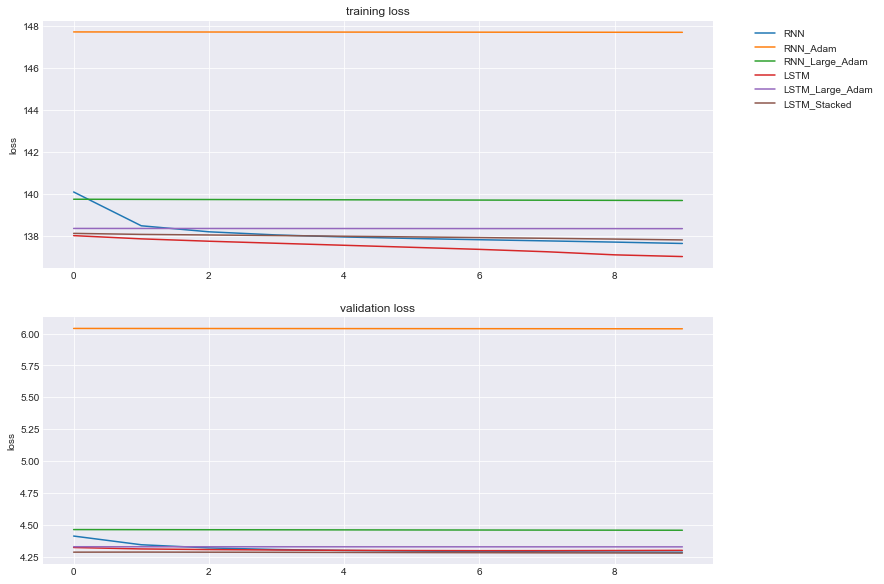

In [11]:
x = [i for i in range(n_epochs)]


fig, ax = plt.subplots(2,1, figsize=(12,10))

for model_ in models:
    name = model_[0]
    training_loss = model_[1]
    valid_loss =model_[2] 

    
    label = name 
    
    ax[0].plot(x,  training_loss, label=label)
    ax[1].plot(x,  valid_loss, label=label)
    #ax[2].plot([i for i in range(n_epochs-1)],  valid_loss[1:] / valid_loss[:-1] * 100, label=label)


#ax[2].set_xlabel('epoch') 

ax[0].set_ylabel('loss') 
ax[1].set_ylabel('loss')

ax[0].set_title("training loss")
ax[1].set_title("validation loss")
#ax[2].set_title("validation loss change in %")

legend  = ax[0].legend(bbox_to_anchor=(1.05, 1))

ax[0].grid()
ax[1].grid()
#ax[2].grid()

# Serializing best model

In [12]:

# =============================================================================
# # Serializing model 
# =============================================================================

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'pytorch_models')
model_name = 'rnn.torch'

if(not os.path.isdir(save_dir)):
    os.mkdir(save_dir)
    
save(model.state_dict(), os.path.join(save_dir, model_name))

#model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
#model.load_state_dict(load( os.path.join(save_dir, model_name)))

# Using model

In [13]:
country = 'Germany'

df = database_training_sv_standard[country].append(database_validation_sv_standard[country])

n_forecast_validation, _ = database_validation_sv_standard[country].shape

X_eval = df.iloc[:,1:].values
y_eval = df.iloc[:,0].values
X_eval_T = from_numpy(X_eval).float()
N, _ = X_eval_T.shape
X_eval_T = X_eval_T.view([-1, N, dummy_dim])

hidden_1 = zeros(1, N, hidden_dim)
state_1 = zeros(1, N, hidden_dim)

hidden_2 = zeros(1, N, hidden_dim)
state_2 = zeros(1, N, hidden_dim)

model.eval()
with no_grad():
    y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)
    
y_hat =  y_hat.view(-1).numpy()
y_forecast = y_hat[-n_forecast_validation:]
y_forecast

array([-0.03215392, -0.06455398, -0.11108989, -0.00174986, -0.01445875,
       -0.03995248], dtype=float32)

# Comparing with the ground truth.

First check right application of scaling. The unscaled data must equal the scaled data after appling the inverse_transform method from sklearn: 

In [14]:
scaler = database_scaler[country]

database_validation_sv[country]

,y,GHG,Crude_oil_production,"Inflation, average consumer prices",Current account balance,ExchangeR,Population,Working_age_population,Fertility_rates,Unemployment rate,Patents_on_environment_technologies,PPP,TOTMAT,Material_consumption,General government net lending/borrowing
2005,2.051359,0.661859,0.627183,1.051777,1.852348,0.547797,0.683857,0.688932,0.624690,0.564285,0.724778,0.654957,0.662340,0.674629,-0.058174
2006,2.518101,0.640522,0.636976,1.167132,1.845025,0.503668,0.683752,0.689639,0.665051,0.530076,0.688231,0.662903,0.670703,0.662517,-1.246360
2007,2.072474,0.661971,0.586901,1.140200,1.786614,0.513078,0.683467,0.690186,0.624690,0.535171,0.742456,0.658295,0.663577,0.659425,-6.907755
2008,2.013436,0.617975,0.590802,0.706676,1.818870,0.583932,0.683149,0.690032,0.624690,0.633615,0.699861,0.662904,0.651967,0.635765,3.318150
2009,0.234375,0.690894,0.585055,1.869612,1.812187,0.582607,0.683654,0.691245,0.624690,0.559735,0.685308,0.665526,0.677563,0.661033,0.607133
2010,1.860920,0.634447,0.671210,1.428403,1.827969,0.525331,0.675119,0.690554,0.624690,0.525254,0.665850,0.659129,0.635187,0.702067,-0.435978


In [15]:
pd.DataFrame(scaler.inverse_transform(database_validation_sv_standard[country]))

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,2.051359,0.661859,0.627183,1.051777,1.852348,0.547797,0.683857,0.688932,0.624690,0.564285,0.724778,0.654957,0.662340,0.674629,-0.058174
1,2.518101,0.640522,0.636976,1.167132,1.845025,0.503668,0.683752,0.689639,0.665051,0.530076,0.688231,0.662903,0.670703,0.662517,-1.246360
2,2.072474,0.661971,0.586901,1.140200,1.786614,0.513078,0.683467,0.690186,0.624690,0.535171,0.742456,0.658295,0.663577,0.659425,-6.907755
3,2.013436,0.617975,0.590802,0.706676,1.818870,0.583932,0.683149,0.690032,0.624690,0.633615,0.699861,0.662904,0.651967,0.635765,3.318150
4,0.234375,0.690894,0.585055,1.869612,1.812187,0.582607,0.683654,0.691245,0.624690,0.559735,0.685308,0.665526,0.677563,0.661033,0.607133
5,1.860920,0.634447,0.671210,1.428403,1.827969,0.525331,0.675119,0.690554,0.624690,0.525254,0.665850,0.659129,0.635187,0.702067,-0.435978


Transforming the output back to original scale: 

In [16]:
df_output = database_validation_sv_standard[country]

Overwriting the forecast to the dataframe in order to call the inverse_transform method.

In [17]:
df_output.iloc[:,0] = y_forecast
df_output

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.032154,0.977376,-0.301234,0.173565,0.233201,0.031546,-0.973685,-0.965081,0.095519,-1.125269,2.440244,-1.811933,0.397665,1.451480,-1.581673
1,-0.064554,-0.824086,0.048749,0.244783,0.229011,-0.691070,-1.036570,-0.674260,1.468828,-1.683832,1.022371,-0.464783,1.083959,0.283843,-5.845020
2,-0.111090,0.986829,-1.740816,0.228155,0.195587,-0.536981,-1.206242,-0.448924,0.095519,-1.600646,3.126048,-1.245999,0.499214,-0.014275,-26.158759
3,-0.001750,-2.727739,-1.601407,-0.039492,0.214045,0.623240,-1.396322,-0.512326,0.095519,0.006758,1.473576,-0.464502,-0.453491,-2.295069,10.532967
4,-0.014459,3.428772,-1.806776,0.678478,0.210220,0.601555,-1.095145,-0.012993,0.095519,-1.199552,0.908968,-0.020067,1.646865,0.140759,0.805523
5,-0.039952,-1.337028,1.272160,0.406086,0.219251,-0.336342,-6.186756,-0.297629,0.095519,-1.762559,0.154082,-1.104656,-1.830473,4.096501,-2.937278


In [18]:
df_output = pd.DataFrame(scaler.inverse_transform(df_output))
df_output

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.609291,0.661859,0.627183,1.051777,1.852348,0.547797,0.683857,0.688932,0.624690,0.564285,0.724778,0.654957,0.662340,0.674629,-0.058174
1,1.551054,0.640522,0.636976,1.167132,1.845025,0.503668,0.683752,0.689639,0.665051,0.530076,0.688231,0.662903,0.670703,0.662517,-1.246360
2,1.467407,0.661971,0.586901,1.140200,1.786614,0.513078,0.683467,0.690186,0.624690,0.535171,0.742456,0.658295,0.663577,0.659425,-6.907755
3,1.663942,0.617975,0.590802,0.706676,1.818870,0.583932,0.683149,0.690032,0.624690,0.633615,0.699861,0.662904,0.651967,0.635765,3.318150
4,1.641098,0.690894,0.585055,1.869612,1.812187,0.582607,0.683654,0.691245,0.624690,0.559735,0.685308,0.665526,0.677563,0.661033,0.607133
5,1.595274,0.634447,0.671210,1.428403,1.827969,0.525331,0.675119,0.690554,0.624690,0.525254,0.665850,0.659129,0.635187,0.702067,-0.435978


In [19]:
y_forecast = df_output.iloc[:,0].values
y_forecast

array([1.60929143, 1.55105364, 1.46740721, 1.6639415 , 1.64109779,
       1.59527384])

In [20]:
database_validation_sv[country].iloc[:,0].values

array([2.05135894, 2.51810131, 2.07247393, 2.01343609, 0.23437483,
       1.86092044])